In [70]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow import RaggedTensor
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
df = pd.read_csv("/home/q674749/workspace/thesis_work/rat25-15.4.1/perception/BERT_NOTEBOOK/final_leading_object_data/combined_file.csv")

In [3]:
list(df)

['timestamp',
 'rcs',
 'distance',
 'angleAzimuth',
 'angleElevation',
 'x_det',
 'y_det',
 'z',
 'radialVelocity',
 'objectID',
 'radialVelocityDomainMax',
 'orientation',
 'x_obj',
 'y_obj',
 'width_edge_mean',
 'length_edge_mean',
 'object_id',
 'header.origin.x',
 'header.origin.y',
 'header.origin.z',
 'header.origin.roll',
 'header.origin.pitch',
 'header.origin.yaw',
 'reference_point',
 'yaw_rate',
 'ego_speed',
 'centroid_x',
 'centroid_y',
 'is_valid_detection']

In [4]:
relevant_columns = ['rcs','x_det','y_det','radialVelocity','ego_speed','centroid_x',
 'centroid_y','orientation']

df_new = df[relevant_columns]

In [5]:
list(df_new)

['rcs',
 'x_det',
 'y_det',
 'radialVelocity',
 'ego_speed',
 'centroid_x',
 'centroid_y',
 'orientation']

In [14]:
df_new.head(2)

,rcs,x_det,y_det,radialVelocity,ego_speed,centroid_x,centroid_y,orientation
0,[-18 -32 -25 -21 -32 -29 -36 -37 -31 -19 -5 -...,[ 5.0138464 6.054301 5.4824324 5.40254...,[-2.4095554e+00 -1.9927621e+00 -2.7368078e+00 ...,[-2.1499999 -2.07 -1.5949999 -1.475 ...,9.703125,[103.43499755859376],[-1.814999938011169],[0.06241573]
1,[-23 -23 -22 -7 -28 -39 -25 -26 -23 -26 -27 -...,[ 4.849637 4.8607 5.1273346 5.11493...,[-2.51193047e+00 -2.56495070e+00 -2.42041469e+...,[-2.4800000e+00 -2.4649999e+00 -3.0400000e+00 ...,20.734375,[52.509998321533196],[2.4099998474121134],[2.3242428]


In [6]:
df_new.shape

(38794, 8)

In [7]:
df_new.isna().sum()

rcs               0
x_det             0
y_det             0
radialVelocity    0
ego_speed         0
centroid_x        0
centroid_y        0
orientation       0
dtype: int64

In [17]:
# Function to convert string representations of NumPy arrays to lists
def convert_to_list(array_str):
    # Remove square brackets and split by spaces
    array_str = array_str.replace("[", "").replace("]", "")
    return [float(x) for x in array_str.split()]

In [18]:
# Apply the conversion to relevant columns
for col in ['rcs', 'x_det', 'y_det', 'radialVelocity']:
    df_new[col] = df_new[col].apply(convert_to_list)

# Inspect the data
print(df_new.head())

/tmp/ipykernel_3776721/3746387052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[col] = df_new[col].apply(convert_to_list)
/tmp/ipykernel_3776721/3746387052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[col] = df_new[col].apply(convert_to_list)
/tmp/ipykernel_3776721/3746387052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

                                                 rcs  \
0  [-18.0, -32.0, -25.0, -21.0, -32.0, -29.0, -36...   
1  [-23.0, -23.0, -22.0, -7.0, -28.0, -39.0, -25....   
2  [-35.0, -28.0, -25.0, -26.0, -35.0, -40.0, -28...   
3  [-34.0, -23.0, -24.0, -27.0, -33.0, -34.0, -24...   
4  [-28.0, -28.0, -26.0, -28.0, -26.0, -26.0, -30...   

                                               x_det  \
0  [5.0138464, 6.054301, 5.4824324, 5.402544, 6.6...   
1  [4.849637, 4.8607, 5.1273346, 5.1149383, 5.930...   
2  [6.6600795, 6.017455, 5.9280252, 5.953123, 6.7...   
3  [5.7291083, 5.6479535, 5.2827706, 6.0945125, 6...   
4  [5.894352, 5.8527813, 6.0481644, 6.1411476, 6....   

                                               y_det  \
0  [-2.4095554, -1.9927621, -2.7368078, -2.849057...   
1  [-2.51193047, -2.5649507, -2.42041469, -2.6207...   
2  [-0.436480641, -2.35650873, -2.48714042, -2.47...   
3  [-2.44097495, -2.52830172, -3.00039482, -2.190...   
4  [-2.47028732, -2.55081868, -2.33068514, -2.

/tmp/ipykernel_3776721/3746387052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[col] = df_new[col].apply(convert_to_list)


In [19]:
df_new.to_csv("BMW.csv", index = False)

In [ ]:
# Split data before normalization to prevent leakage
train_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42)

# Create scalers
detection_scaler = StandardScaler()
scalar_scaler = StandardScaler()

# Flatten the nested lists for fitting the scaler
def flatten_nested_lists(column):
    """Flatten a column of nested lists into a single array"""
    return np.concatenate(column.values)

# Fit scalers on training data
detection_scaler.fit(np.column_stack([
    flatten_nested_lists(train_df['rcs']),
    flatten_nested_lists(train_df['x_det']),
    flatten_nested_lists(train_df['y_det']),
    flatten_nested_lists(train_df['radialVelocity'])
]))
scalar_scaler.fit(train_df[["ego_speed"]].values)





In [40]:


def preprocess(row):
    """Process individual samples maintaining dynamic detection counts"""
    # Stack detection features into a 2D array (n_detections x 4)
    detections = np.column_stack([
        row['rcs'],
        row['x_det'],
        row['y_det'],
        row['radialVelocity']
    ])
    
    # Normalize detections (all 4 features at once)
    normalized_detections = detection_scaler.transform(detections)
    
    # Normalize ego speed
    scaled_ego = scalar_scaler.transform([[row['ego_speed']]]).flatten()
    
    # Extract numerical values from string representations of lists
    centroid_x = float(ast.literal_eval(row['centroid_x'])[0])
    centroid_y = float(ast.literal_eval(row['centroid_y'])[0])
    orientation = float(ast.literal_eval(row['orientation'])[0])
    
    # Ensure labels are floats
    labels = [centroid_x, centroid_y, orientation]
    
    return {
        "detections": normalized_detections,
        "ego_speed": scaled_ego,
        "labels": labels
    }

In [41]:
# Apply preprocessing
train_data = [preprocess(row) for _, row in train_df.iterrows()]
test_data = [preprocess(row) for _, row in test_df.iterrows()]

In [45]:
def create_dataset(data):
    """Convert to TF RaggedTensor dataset"""
    detections = [sample["detections"] for sample in data]
    ego_speeds = [sample["ego_speed"] for sample in data]
    labels = [sample["labels"] for sample in data]
    
    # Create RaggedTensor for detections
    ragged_detections = tf.ragged.constant(detections)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "detections": ragged_detections,
            "ego_speed": tf.convert_to_tensor(ego_speeds)
        },
        tf.convert_to_tensor(labels)
    ))
    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_dataset = create_dataset(train_data)
test_dataset = create_dataset(test_data)

2025-03-01 12:55:28.668171: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 625993472 exceeds 10% of free system memory.


In [44]:
# Print the first sample's labels
print("First sample labels:", train_data[0]["labels"])

First sample labels: [151.72499847412112, -3.2899999618530273, 0.0017257805]


In [36]:
print(train_df[["centroid_x", "centroid_y", "orientation"]].dtypes)

centroid_x     object
centroid_y     object
orientation    object
dtype: object


In [46]:


class RadarPointNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        # Shared MLP for individual detections
        self.shared_mlp = tf.keras.Sequential([
            Dense(64, activation="relu"),
            Dense(128, activation="relu"),
            Dense(256, activation="relu")
        ])
        
        # Feature aggregation
        self.global_pool = Lambda(lambda x: tf.reduce_max(x, axis=1))
        
        # Combined processing
        self.combined_mlp = tf.keras.Sequential([
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(3)  # Predict x, y, orientation
        ])
    
    def call(self, inputs):
        # Process detections
        detections = inputs["detections"]
        ego_speed = inputs["ego_speed"]
        
        # Convert ragged tensor to dense for processing
        flat_detections = detections.to_tensor()
        
        # Ensure the input shape is defined
        flat_detections = tf.ensure_shape(flat_detections, [None, None, 4])  # (batch_size, max_detections, 4)
        
        # Process each detection independently
        point_features = self.shared_mlp(flat_detections)
        
        # Preserve ragged structure for correct pooling
        ragged_features = tf.RaggedTensor.from_tensor(
            point_features,
            row_splits_dtype=detections.row_splits.dtype
        )
        
        # Global feature aggregation
        global_features = self.global_pool(ragged_features)
        
        # Combine with ego speed
        combined = Concatenate()([global_features, ego_speed])
        
        # Final prediction
        return self.combined_mlp(combined)

In [47]:
# Create the model
model = RadarPointNet()

# Compile the model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50


970/970 [==============================] - 95s 96ms/step - loss: 1032.2419 - mae: 15.6377 - val_loss: 358.8625 - val_mae: 9.6521
Epoch 2/50
970/970 [==============================] - 92s 95ms/step - loss: 244.3614 - mae: 7.9595 - val_loss: 155.7210 - val_mae: 6.4665
Epoch 3/50
970/970 [==============================] - 93s 96ms/step - loss: 109.3938 - mae: 5.3853 - val_loss: 63.7357 - val_mae: 4.3670
Epoch 4/50
970/970 [==============================] - 94s 96ms/step - loss: 55.4749 - mae: 4.0796 - val_loss: 36.4001 - val_mae: 3.4382
Epoch 5/50
970/970 [==============================] - 94s 97ms/step - loss: 29.8728 - mae: 3.1811 - val_loss: 22.7474 - val_mae: 2.9313
Epoch 6/50
970/970 [==============================] - 94s 97ms/step - loss: 23.9277 - mae: 2.8504 - val_loss: 38.0757 - val_mae: 3.6404
Epoch 7/50
970/970 [==============================] - 94s 96ms/step - loss: 17.9850 - mae: 2.5205 - val_loss: 19.9228 - val_mae: 2.7960
Epoch 8/50
970/970 [==============================] 

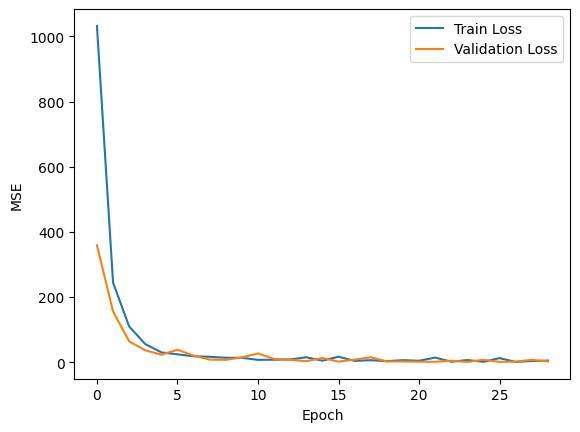

In [49]:


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

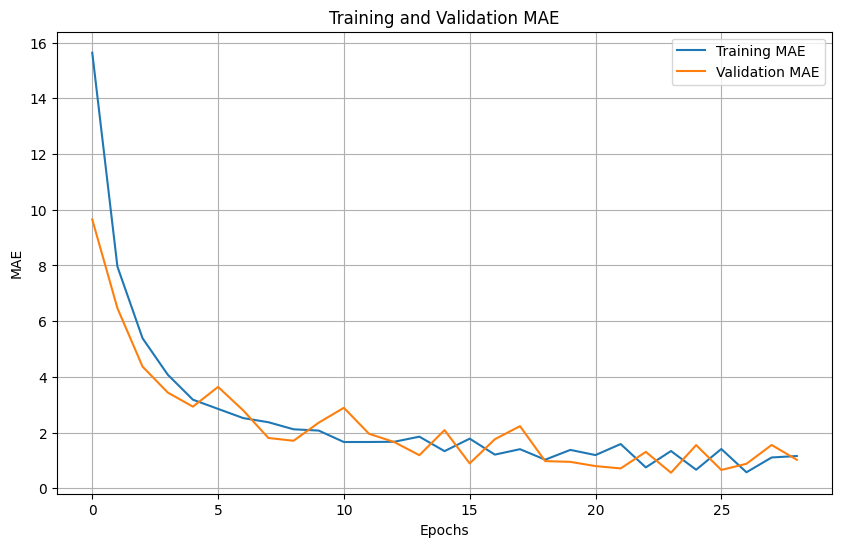

In [50]:
# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

243/243 [==============================] - 8s 32ms/step


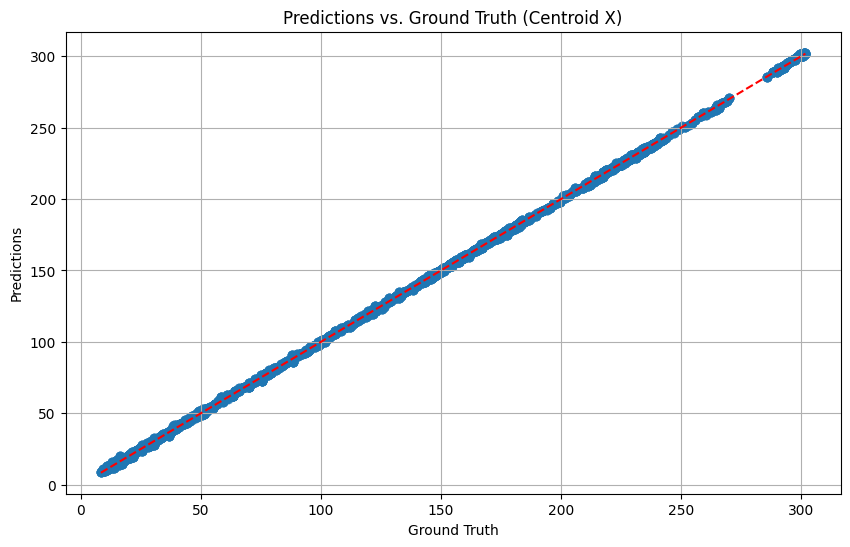

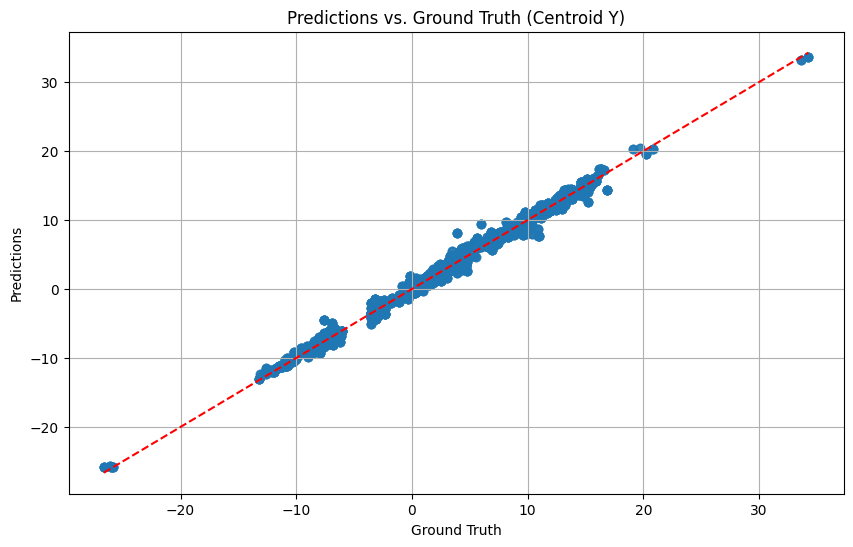

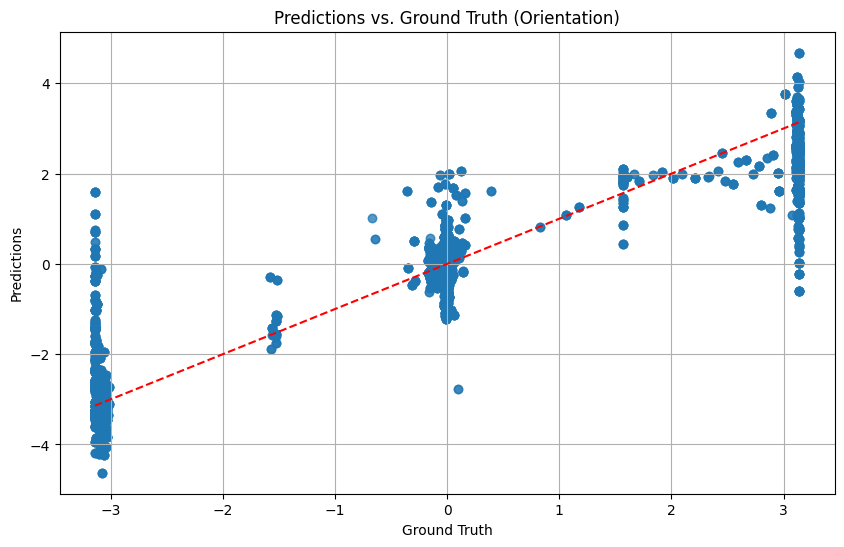

In [51]:
# Get predictions for the test dataset
y_pred = model.predict(test_dataset)

# Extract ground truth labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Plot predictions vs. ground truth for centroid_x
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5)
plt.plot([min(y_true[:, 0]), max(y_true[:, 0])], [min(y_true[:, 0]), max(y_true[:, 0])], 'r--')
plt.title('Predictions vs. Ground Truth (Centroid X)')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.grid()
plt.show()

# Plot predictions vs. ground truth for centroid_y
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.5)
plt.plot([min(y_true[:, 1]), max(y_true[:, 1])], [min(y_true[:, 1]), max(y_true[:, 1])], 'r--')
plt.title('Predictions vs. Ground Truth (Centroid Y)')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.grid()
plt.show()

# Plot predictions vs. ground truth for orientation
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:, 2], y_pred[:, 2], alpha=0.5)
plt.plot([min(y_true[:, 2]), max(y_true[:, 2])], [min(y_true[:, 2]), max(y_true[:, 2])], 'r--')
plt.title('Predictions vs. Ground Truth (Orientation)')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.grid()
plt.show()

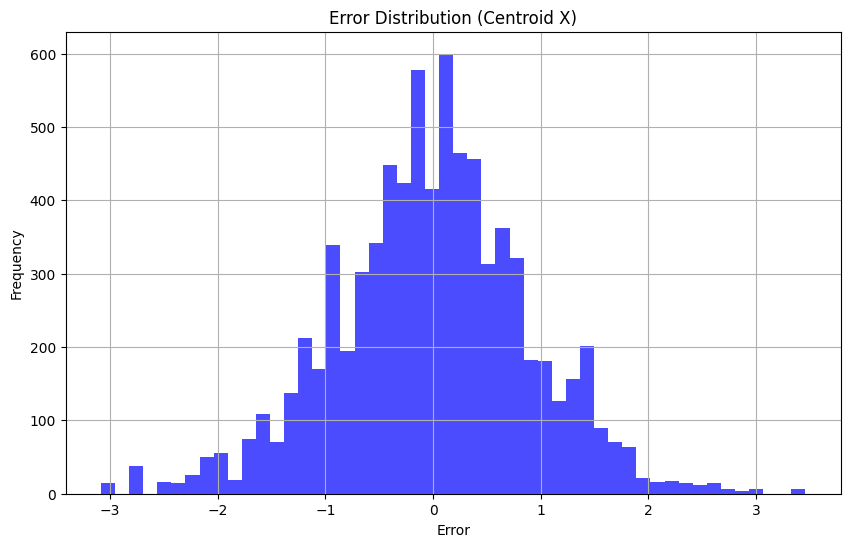

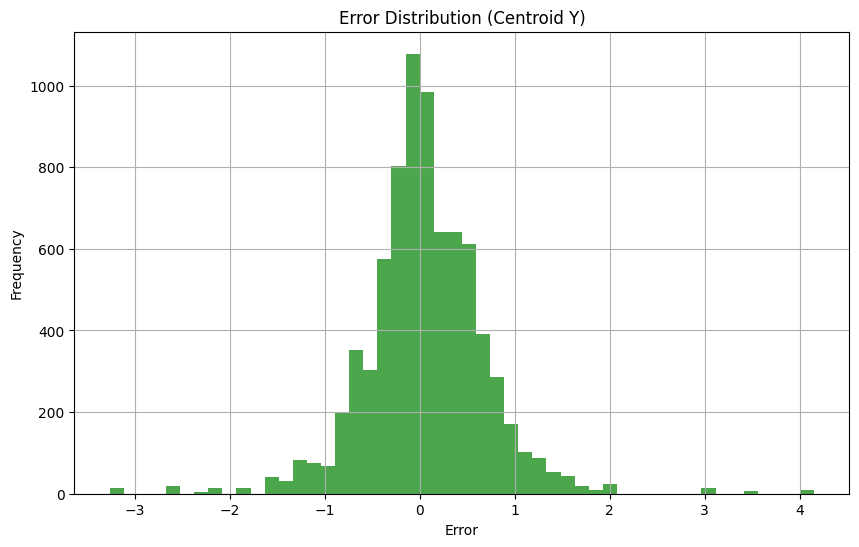

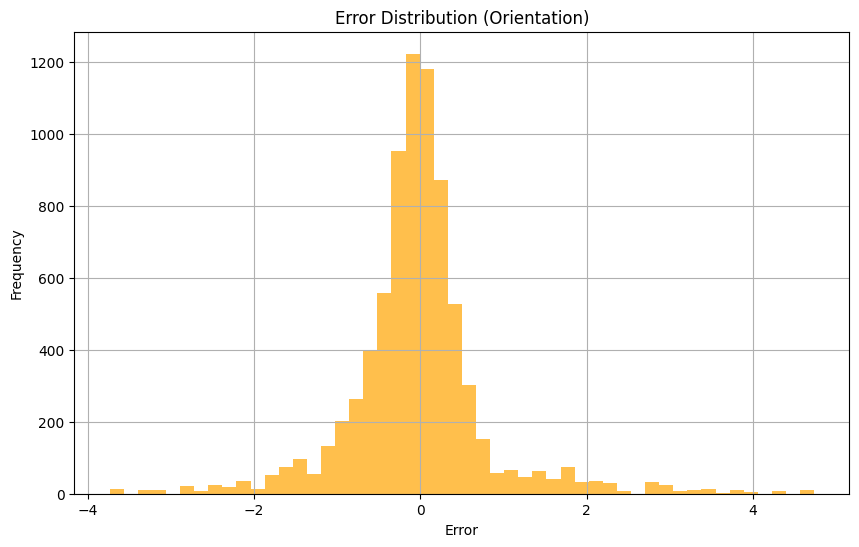

In [52]:
# Calculate errors
errors = y_pred - y_true

# Plot error distribution for centroid_x
plt.figure(figsize=(10, 6))
plt.hist(errors[:, 0], bins=50, alpha=0.7, color='blue')
plt.title('Error Distribution (Centroid X)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot error distribution for centroid_y
plt.figure(figsize=(10, 6))
plt.hist(errors[:, 1], bins=50, alpha=0.7, color='green')
plt.title('Error Distribution (Centroid Y)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot error distribution for orientation
plt.figure(figsize=(10, 6))
plt.hist(errors[:, 2], bins=50, alpha=0.7, color='orange')
plt.title('Error Distribution (Orientation)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [57]:
# Save the model in SavedModel format
model.save('radar_pointnet_model', save_format='tf')

INFO:tensorflow:Assets written to: radar_pointnet_model/assets


INFO:tensorflow:Assets written to: radar_pointnet_model/assets


In [58]:
# testing on test data

In [59]:
# Get predictions for the test dataset
y_pred = model.predict(test_dataset)

# Extract ground truth labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

243/243 [==============================] - 8s 31ms/step


In [60]:
# Extract input features
test_features = []
for x, _ in test_dataset:
    test_features.append({
        "detections": x["detections"].numpy(),
        "ego_speed": x["ego_speed"].numpy()
    })

In [61]:
# Create a DataFrame for the test data
test_results = []

for i, (features, true_labels) in enumerate(zip(test_features, y_true)):
    # Extract detections and ego speed
    detections = features["detections"]
    ego_speed = features["ego_speed"][0]  # Scalar value
    
    # Extract ground truth and predictions
    true_centroid_x, true_centroid_y, true_orientation = true_labels
    pred_centroid_x, pred_centroid_y, pred_orientation = y_pred[i]
    
    # Append to the results list
    test_results.append({
        "Ego Speed": ego_speed,
        "Detections": detections,
        "True Centroid X": true_centroid_x,
        "True Centroid Y": true_centroid_y,
        "True Orientation": true_orientation,
        "Pred Centroid X": pred_centroid_x,
        "Pred Centroid Y": pred_centroid_y,
        "Pred Orientation": pred_orientation
    })

# Convert to a DataFrame
results_df = pd.DataFrame(test_results)

In [62]:
results_df.head()

,Ego Speed,Detections,True Centroid X,True Centroid Y,True Orientation,Pred Centroid X,Pred Centroid Y,Pred Orientation
0,[1.2587298354070713],"[[[-2.812523532377225, -1.2497674852134057, 0....",88.569992,11.030,-3.049358,87.715614,11.196609,-2.834596
1,[0.8146252336290973],"[[[-3.039436248949358, -1.2299752570005473, 0....",226.154999,-7.050,-0.017450,227.501358,-7.272768,0.021704
2,[1.227848389588073],"[[[-2.7368859601865143, -1.256944910375418, 0....",51.654999,-10.850,-0.152156,53.104092,-11.147063,-0.321744
3,[-0.893412829169302],"[[[-2.4343356714236712, -1.2619277985062125, 0...",67.270004,2.565,3.127881,67.552597,2.435019,2.811578
4,[1.213878211717574],"[[[0.061704210869785905, -1.2568607143461854, ...",133.990005,-0.570,3.125772,134.835968,-0.962861,0.576260


In [ ]:
# predictions

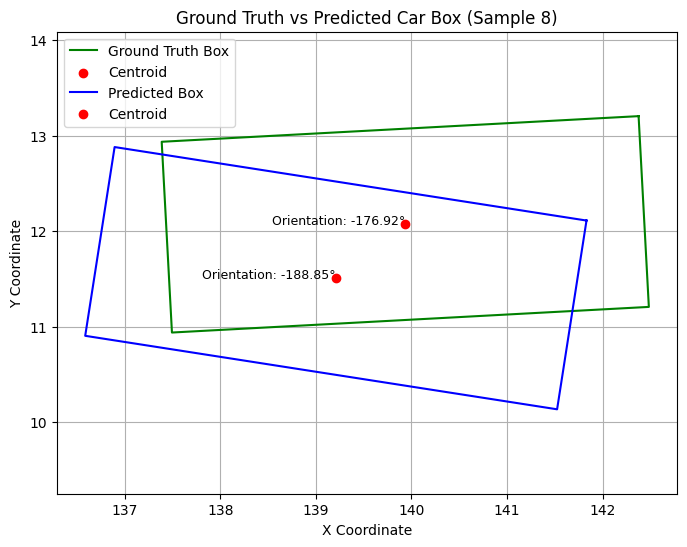

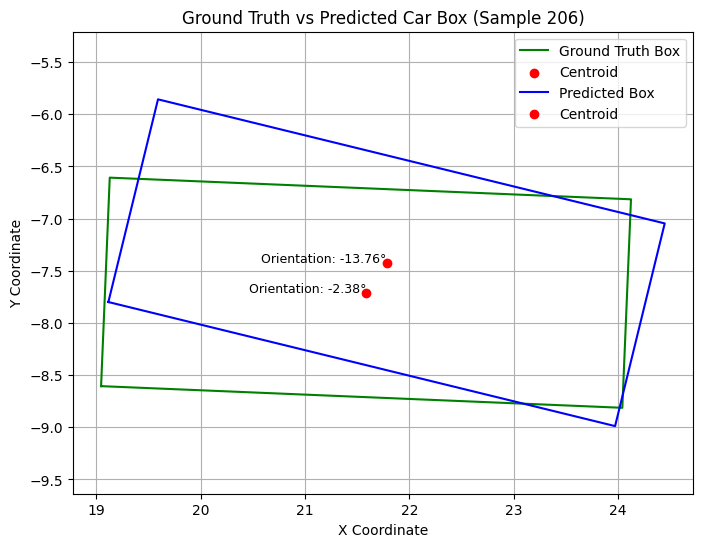

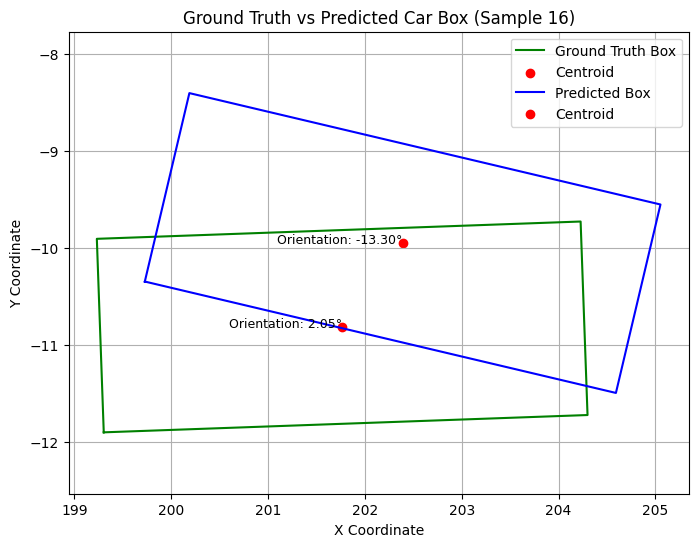

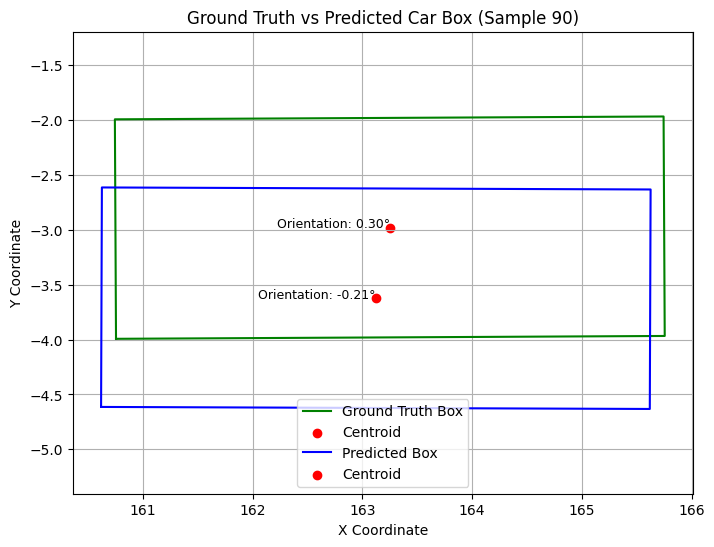

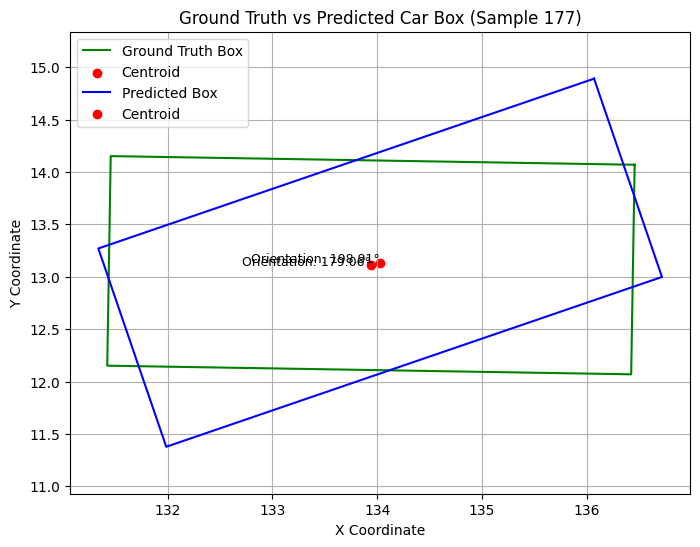

In [68]:
# Randomly select 5 indices
random_indices = np.random.choice(len(results_df), size=5, replace=False)
# Plot each pair (ground truth vs prediction)
for idx in random_indices:
    plt.figure(figsize=(8, 6))
    
    # Ground truth
    gt_centroid_x = results_df.loc[idx, 'True Centroid X']
    gt_centroid_y = results_df.loc[idx, 'True Centroid Y']
    gt_orientation = results_df.loc[idx, 'True Orientation']
    plot_box(gt_centroid_x, gt_centroid_y, gt_orientation, color='g', label='Ground Truth Box')
    
    # Predictions
    pred_centroid_x = results_df.loc[idx, 'Pred Centroid X']
    pred_centroid_y = results_df.loc[idx, 'Pred Centroid Y']
    pred_orientation = results_df.loc[idx, 'Pred Orientation']
    plot_box(pred_centroid_x, pred_centroid_y, pred_orientation, color='b', label='Predicted Box')
    
    # Customize the plot
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Ground Truth vs Predicted Car Box (Sample {idx + 1})')
    plt.legend()
    plt.grid()
    plt.axis('equal')  # Ensure equal scaling for X and Y axes
    plt.show()

In [ ]:


# Extract ground truth and predictions
y_true = results_df[['True Centroid X', 'True Centroid Y', 'True Orientation']].values
y_pred = results_df[['Pred Centroid X', 'Pred Centroid Y', 'Pred Orientation']].values

# Calculate metrics for each output variable
metrics = {}
for i, col in enumerate(['Centroid X', 'Centroid Y', 'Orientation']):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    
    metrics[col] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Print the metrics
for col, values in metrics.items():
    print(f"Metrics for {col}:")
    for metric, value in values.items():
        print(f"  {metric}: {value:.4f}")

Metrics for Centroid X:
  MAE: 0.6700
  MSE: 0.7427
  RMSE: 0.8618
  R²: 0.9999
Metrics for Centroid Y:
  MAE: 0.4296
  MSE: 0.3362
  RMSE: 0.5798
  R²: 0.9951
Metrics for Orientation:
  MAE: 0.5321
  MSE: 0.6855
  RMSE: 0.8279
  R²: 0.8435
